In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

ROOT_DIR = os.path.abspath("../")

In [7]:
def plot_loss(
    run: str,
    layers: str,
    loss_type: str,
    ylim: float = None
):
    print(f'{layers} {loss_type} loss')

    loss = pd.read_csv(os.path.join(ROOT_DIR, 'training_curves', run, 'epoch_{}_{}_loss.csv'.format(layers.lower(), loss_type.lower())))
    loss_val = pd.read_csv(os.path.join(ROOT_DIR, 'training_curves', run, 'epoch_val_{}_{}_loss.csv'.format(layers.lower(), loss_type.lower())))

    plt.figure()
    plt.plot(loss['Step'], loss['Value'], label='Train')
    plt.plot(loss_val['Step'], loss_val['Value'], label='Val')

    if ylim:
        plt.ylim(ylim[0], ylim[1])

    plt.xlabel('Epoch')
    plt.ylabel(f'{layers} {loss_type} Loss')
    plt.legend()
    plt.show()

MRCNN Mask loss


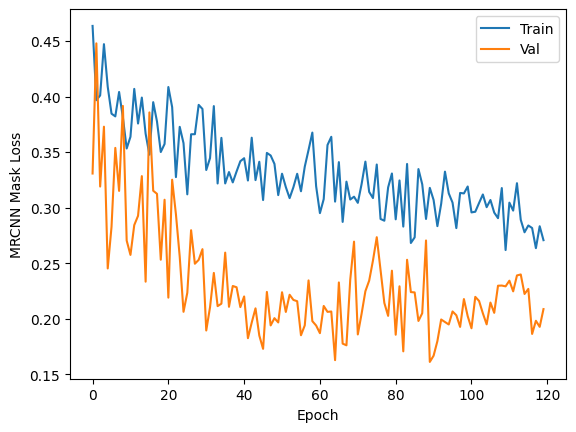

MRCNN Class loss


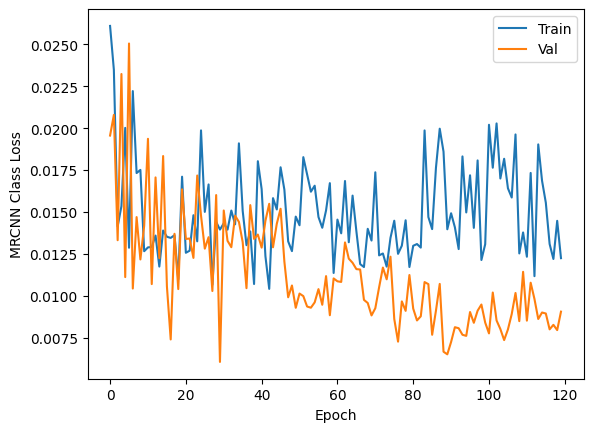

MRCNN bbox loss


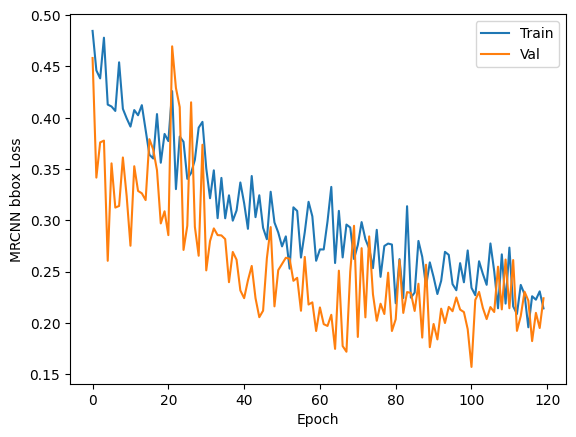

RPN Class loss


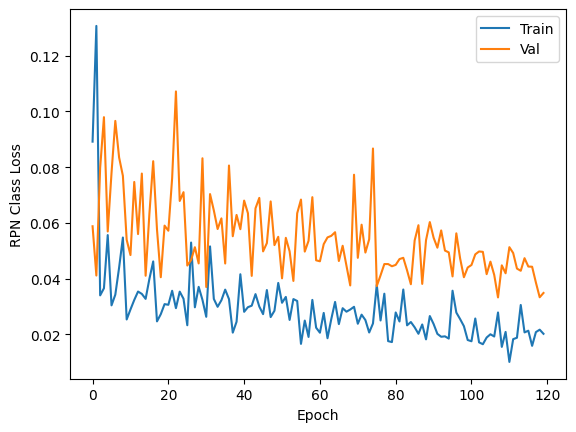

RPN bbox loss


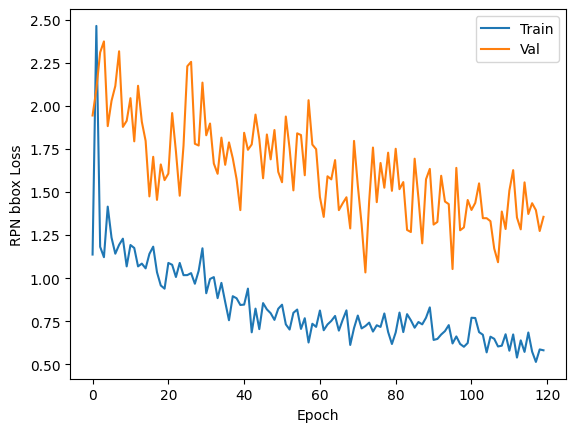

In [9]:
run = 'tdm20241118T1338'
layers = 'MRCNN'
plot_loss(run, layers, 'Mask')
plot_loss(run, layers, 'Class')
plot_loss(run, layers, 'bbox')
layers = "RPN"
plot_loss(run, layers, 'Class')
plot_loss(run, layers, 'bbox')